## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

## Load the dataset

We will load the individual dataset, create a target attribute which will indicate '1' if the news is fake. Combine both the dataframes and create the combine dataframe for modelling

In [2]:
# load the fake and real news datasets
fake_news = pd.read_csv("https://raw.githubusercontent.com/SandeepTukkunor/fake_news_classification_using_LSTM/master/True.csv")
fake_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
true_news = pd.read_csv("https://raw.githubusercontent.com/SandeepTukkunor/fake_news_classification_using_LSTM/master/True.csv")
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Create a column with fake=1 in fake_news dataset
fake_news['fake']=1
fake_news.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
# Create a column with fake=0 in true_news dataset
true_news['fake'] = 0
true_news.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
# Concat two fake and true news
news = pd.concat([fake_news, true_news])
news.sample(5)

,title,text,subject,date,fake
8074,European Union asks Obama to stop 9/11 Saudi bill,WASHINGTON (Reuters) - The European Union on W...,politicsNews,"September 21, 2016",0
4970,"Boeing, aerospace manufacturers back U.S. tax ...",SEATTLE (Reuters) - Boeing Co and about 90 oth...,politicsNews,"March 14, 2017",0
19822,U.N. chief: Northern Iraq vote would detract f...,UNITED NATIONS (Reuters) - United Nations Secr...,worldnews,"September 17, 2017",1
14807,Alaska Airlines discontinues Los Angeles-Havan...,(Reuters) - U.S. airline Alaska Airlines on Tu...,worldnews,"November 15, 2017",1
16294,EU Commission has no new comment on Catalonia ...,BRUSSELS (Reuters) - The European Commission s...,worldnews,"October 27, 2017",1


In [7]:
# Check for any null values
news.isna().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

In [8]:
# Check the info
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42834 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    42834 non-null  object
 1   text     42834 non-null  object
 2   subject  42834 non-null  object
 3   date     42834 non-null  object
 4   fake     42834 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


## Exploratory Data Analysis and Data Visualizations

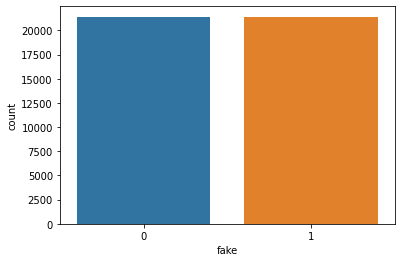

In [9]:
# Explore the target variable
sns.countplot(x='fake', data=news)


In [10]:
# Explore 2 text for the fake dataset
news[news['fake']==1]['text'].head(2)

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
Name: text, dtype: object

In [11]:
# Explore 2 text for true news
news[news['fake']==0]['text'].head(2)

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
Name: text, dtype: object

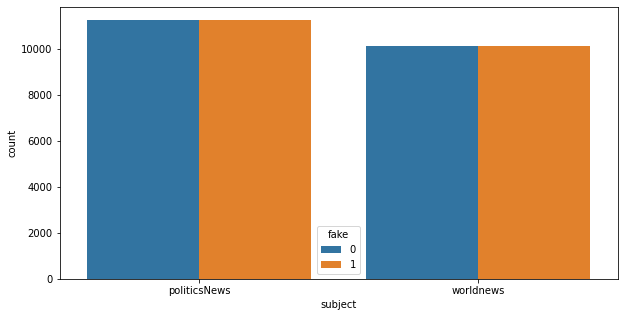

In [12]:
# Explore the subject column
plt.figure(figsize=(10,5))
sns.countplot(x='subject', data=news, hue='fake')

## Feature Engineering

We will create a new columns calld Month and Year from Date and Analyse whether fake or true news has some correlation with Month or Year in the timeline

In [13]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,fake,Year,Month
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017,12
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017,12
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017,12
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017,12
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017,12


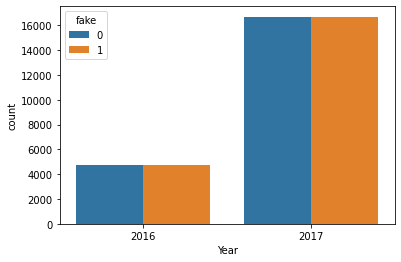

In [14]:
# check the impact of yead on tha target
sns.countplot(x='Year', data=news, hue='fake')

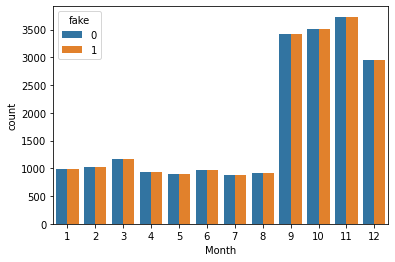

In [15]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='fake')

**We will combine the title and text column**

In [16]:
news['text'] = news['title'] + news['text']
news.drop(labels=['title'], axis=1,inplace=True)
news.head()

,text,subject,date,fake,Year,Month
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,2017-12-31,1,2017,12
1,U.S. military to accept transgender recruits o...,politicsNews,2017-12-29,1,2017,12
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,2017-12-31,1,2017,12
3,FBI Russia probe helped by Australian diplomat...,politicsNews,2017-12-30,1,2017,12
4,Trump wants Postal Service to charge 'much mor...,politicsNews,2017-12-29,1,2017,12


## Preparing the final data

We will remove the subject attribute - Since it perfectly distributes the target variable We will remove the Year attribute - This also has a clear division for the target variable We will remove the Month Attribute - This also has a very clear approach of demarcating the target variable

For now we will just go ahead with the "text attribute"

In [17]:
news.drop(labels=['subject','date', 'Year','Month'], axis=1, inplace=True)
news.head()

,text,fake
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


## Split the dataset into training and testing

In [18]:
# We will shuffle the dataframe and extract the feature and label
news = news.sample(frac=1)
news.head()

,text,fake
15155,Lebanon's grand mufti calls for national unity...,1
21264,Iran rejects U.S. demand for U.N. visit to mil...,1
13096,Trump speaking by phone with Israel's Netanyah...,1
19478,North Korea says sanctions threaten survival o...,1
14146,Italian left's efforts to stop migrants may ba...,0


In [19]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels=train_test_split(news['text'].to_numpy(),
                                                                            news['fake'].to_numpy(),
                                                                            test_size=0.2,
                                                                            random_state=42)


In [20]:
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(34267, 8567, 34267, 8567)

In [21]:
# Check the first 10 samples
train_sentences[:2], train_labels[:10]

(array(['Brexit campaigner Farage to attend Trump inaugurationLONDON (Reuters) - Leading Brexit campaigner Nigel Farage, who has said he wants to be a bridge between the British government and the new U.S. administration, will attend U.S. President-elect Donald Trump’s inauguration later this month. Farage, who will attend the event as a guest of Mississippi Governor Phil Bryant, spoke at a Trump rally in Mississippi during the U.S. presidential campaign and was the first British politician to meet the president-elect after his victory, ahead of Prime Minister Theresa May. Farage spent decades campaigning for Britain to leave the European Union and helped to force then Prime Minister David Cameron to call the June 2016 referendum that resulted in the Brexit vote. Trump has said Farage - the former leader of the United Kingdom Independence Party (UKIP) - would be great as Britain’s envoy to Washington, but the British government has dismissed the suggestion. Asked if he would be attendi

## Converting text into numbers
When dealing with a text problem, one of the first things you'll have to do before you cna build a model is to covert your text to numbers.

There are a few ways to do this, namely:

* Tokenization -direct mapping of token (a token could be a word or a character ) to a number.
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).


## Text Vectorization (tokenization)

In [22]:
# find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

395

In [23]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 418


from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode='int',
                                   output_sequence_length=max_length)

In [24]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [25]:
# Create a sample sentences and tekenize it
sample_sentence = "Please Do Not Forget To Upvoted"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 418), dtype=int64, numpy=
array([[5305,  146,   26, 7344,    3,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [26]:
# choose a random sentence from the training dataset and tokeize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text;\n{random_sentence}\
\n\n Vectorized Version:")
text_vectorizer([random_sentence])

Original text;
Japan PM and U.S. president discuss North Korea's missile launches: mediaTOKYO (Reuters) - Japanese Prime Minister Shinzo Abe and U.S. President Donald Trump discussed North Korea’s missile launches during a phone call on Tuesday, the Jiji and Kyodo news agencies reported on Tuesday. North Korea fired four ballistic missiles into the sea off Japan’s northwest coast on Monday, angering South Korea and Japan, days after it promised retaliation over U.S.-South Korea military drills it sees as preparation for war. 

 Vectorized Version:


<tf.Tensor: shape=(1, 418), dtype=int64, numpy=
array([[ 509, 1336,    7,   22,   37,  667,   76, 5742,  341, 4239,    1,
          32, 1267,  225,   93, 3109, 1119,    7,   22,   37,   83,   18,
        1049,   76, 2410,  341, 4239,  123,    5,  987,  353,    8,  112,
           2,    1,    7,    1,  165,  542,  285,    8,  112,   76,  120,
         897,  314, 1141, 1175,   89,    2,  802,  297, 5431, 4334, 1524,
           8,  135, 8747,  172,  120,    7,  509,  273,   41,   21, 1074,
        3323,   58, 9670,  120,  101, 3258,   21, 1893,   17, 6672,   11,
         204,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [27]:
words = text_vectorizer.get_vocabulary()
len(words)

10000

## Creating an Embedding using an Embedding Layer
To make our embedding we're going to use TensorFlow's embedding layer

The parameters we care most about for our embedding layer:

* input_dim = the size of our vocabulary
* output_dim = the size of output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the sequences being passed to be embedding layer

In [28]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            embeddings_initializer='uniform',
                            input_length=max_length)
embedding

In [29]:
# Get a random sentence from the training set
random_sentenc = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedd version: ")
embedding(text_vectorizer([random_sentence]))

Original text:
Japan PM and U.S. president discuss North Korea's missile launches: mediaTOKYO (Reuters) - Japanese Prime Minister Shinzo Abe and U.S. President Donald Trump discussed North Korea’s missile launches during a phone call on Tuesday, the Jiji and Kyodo news agencies reported on Tuesday. North Korea fired four ballistic missiles into the sea off Japan’s northwest coast on Monday, angering South Korea and Japan, days after it promised retaliation over U.S.-South Korea military drills it sees as preparation for war.       

Embedd version: 


<tf.Tensor: shape=(1, 418, 128), dtype=float32, numpy=
array([[[ 0.00044893, -0.0235617 ,  0.00494645, ...,  0.04428894,
          0.03473036, -0.04655664],
        [-0.0002218 , -0.04033143, -0.01394868, ...,  0.02464292,
         -0.04852405, -0.02552166],
        [-0.04509643,  0.00209938, -0.01471406, ...,  0.03566981,
          0.01707724,  0.01411429],
        ...,
        [ 0.00803437,  0.00078448,  0.01724854, ..., -0.03408003,
         -0.04497719,  0.01995859],
        [ 0.00803437,  0.00078448,  0.01724854, ..., -0.03408003,
         -0.04497719,  0.01995859],
        [ 0.00803437,  0.00078448,  0.01724854, ..., -0.03408003,
         -0.04497719,  0.01995859]]], dtype=float32)>

## Modelling

We will be using LSTM(long-short term memory) neural network.

In [30]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype='string')

# Pass inputs to text_vectorizer(convert text into numbers)
x = text_vectorizer(inputs) 

# Convert text_vectorizer layer into embedding layer
x = embedding(x)

# Model 
x = layers.LSTM(64)(x)


# output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Pass inputs and outputs to our model
model = tf.keras.Model(inputs, outputs, name='model_LSTM')

In [31]:
# Get a summary
model.summary()

Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 418)               0         
_________________________________________________________________
embedding (Embedding)        (None, 418, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [33]:
# Fit the model
model_history = model.fit(train_sentences,
                         train_labels,
                          epochs=5,
                         validation_data=(val_sentences, val_labels))

Epoch 1/5
1071/1071 [==============================] - 124s 110ms/step - loss: 0.6935 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5043
Epoch 2/5
1071/1071 [==============================] - 117s 109ms/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 3/5
1071/1071 [==============================] - 116s 108ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 4/5
1071/1071 [==============================] - 116s 108ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6933 - val_accuracy: 0.4973
Epoch 5/5
1071/1071 [==============================] - 116s 109ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5073


**We got 99% accuracy on valid data**

In [34]:
# Make predictions 
model_prediction = model.predict(val_sentences)
model_prediction[:10]

array([[0.49264273],
       [0.49264285],
       [0.49264464],
       [0.49195856],
       [0.49264285],
       [0.49351615],
       [0.49264285],
       [0.49264285],
       [0.49264285],
       [0.49277017]], dtype=float32)

In [35]:
# Convert model prediction to our val_labels
model_preds = tf.squeeze(tf.round(model_prediction))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [36]:
# Evaluatinon metrics
from sklearn.metrics import accuracy_score, recall_score,precision_score, f1_score

print(f"Accuracy Score: {accuracy_score(val_labels,model_preds)}")
print(f"Recall Score : {recall_score(val_labels, model_preds)}")
print(f"Precsion Score : {precision_score(val_labels, model_preds)}")
print(f"f1 Score : {f1_score(val_labels, model_preds)}")

Accuracy Score: 0.5072954359752538
Recall Score : 0.09129213483146068
Precsion Score : 0.5349794238683128
f1 Score : 0.15596880623875223


**References for Feature Engineering and EDA**: https://www.kaggle.com/suvofalcon/fake-real-news-tensorflow-hub-99-accuracy